# Weather and AIR Quality Data Prediction using Machine Learning

In this project, we leverage machine learning techniques to analyze weather and pollutant data for predictive modeling. Our goal is to identify patterns in environmental factors and to study the influence of the varaiables on Air Quality Index using historical data. The dataset includes various meteorological and pollutant parameters, and we apply preprocessing, feature engineering, and modeling techniques to derive meaningful insights.

Below is a section of the code implementing data processing and model training:


## Importing Libraries

Below, we import the necessary Python libraries for data analysis, preprocessing, feature selection, model training, and evaluation:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Loading the Dataset

We begin by loading the dataset containing weather and aquatic data. The dataset is stored in an `.xls` file and is read into a Pandas DataFrame for further processing.


In [3]:
df=pd.read_csv('aqi.csv')

## Cleaning Column Names

To ensure consistency and avoid errors due to unwanted spaces, we strip any leading or trailing whitespace from column names in the dataset.


In [4]:
df.columns = df.columns.str.strip()

## Creating Lag Features

To capture temporal dependencies in the data, we generate lag features for the `AQI` variable. This allows the model to use AQI values from the past 7 days as predictors, improving its ability to recognize trends and patterns over time.


In [5]:
for lag in range(1, 8):  # Lag for past 7 days
    df[f"AQI_lag_{lag}"] = df["AQI"].shift(lag)

## Calculating 7-Day Moving Average

To smooth fluctuations and capture long-term trends, we compute a 7-day rolling average for the `AQI` variable. This feature helps in understanding broader patterns in air quality variations.


In [6]:
df["AQI_7_day_avg"] = df["AQI"].rolling(window=7).mean()

## Creating Interaction Features

To enhance the model's predictive power, we generate new features by combining key environmental variables. These interaction features help capture relationships between different meteorological and air quality parameters:

- **Wind_PM10**: Wind speed (`V`) multiplied by PM10 concentration (`pm10`).
- **Humidity_Temp**: Humidity (`H`) multiplied by temperature (`T`).
- **Wind_NO2**: Wind speed (`V`) multiplied by NO2 concentration (`no2`).
- **Temp_Pressure**: Temperature (`T`) multiplied by atmospheric pressure (`PP`).
- **Rain_PM10**: Rainfall (`RA`) multiplied by PM10 concentration (`pm10`).

Additional interaction terms include:
- **Wind_SO2, Rain_NO2, Rain_SO2, Temp_NO2, Temp_SO2, Fog_PM10**, which further explore relationships between meteorological factors and air pollutants.

These engineered features help the model identify complex dependencies that might not be obvious in individual variables.


In [7]:
df["Wind_PM10"] = df["V"] * df["pm10"]
df["Humidity_Temp"] = df["H"] * df["T"]
df["Wind_NO2"] = df["V"] * df["no2"]
df["Temp_Pressure"] = df["T"] * df["PP"]
df["Rain_PM10"] = df["RA"] * df["pm10"]

df["Wind_SO2"] = df["V"] * df["so2"]
df["Rain_NO2"] = df["RA"] * df["no2"]
df["Rain_SO2"] = df["RA"] * df["so2"]
df["Temp_NO2"] = df["T"] * df["no2"]
df["Temp_SO2"] = df["T"] * df["so2"]
df["Fog_PM10"] = df["FG"] * df["pm10"]

## Handling Missing Values

To ensure data quality and prevent errors during model training, we remove any rows containing missing values from the dataset. This step ensures that all features used for modeling are complete and reliable.


In [8]:
df.dropna(inplace=True)

## Feature Selection using Mutual Information

To identify the most relevant features for predicting `AQI`, we use **Mutual Information (MI) Regression**. This technique measures the dependency between each feature and the target variable (`AQI`), helping us determine which variables contribute the most to the model.

### Steps:
1. **Define Features (`X`) and Target (`y`)**: We separate `AQI` as the target variable and use all other columns as input features.
2. **Compute Mutual Information Scores**: We calculate MI scores for each feature to quantify their relevance.
3. **Sort Features by Importance**: Higher MI scores indicate stronger relationships with `AQI`.

The sorted MI scores will help us select the most influential features for our model.


In [9]:
X = df.drop(columns=["AQI"])
y = df["AQI"]

# Calculate Mutual Information Scores
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
mi_scores

pm10             4.356334
Rain_PM10        4.037963
Fog_PM10         2.500023
AQI_lag_1        0.670419
Wind_PM10        0.644596
AQI_7_day_avg    0.616855
AQI_lag_2        0.459931
AQI_lag_3        0.368678
AQI_lag_4        0.326291
Year             0.309996
AQI_lag_5        0.273986
AQI_lag_7        0.250355
AQI_lag_6        0.239316
Humidity_Temp    0.234805
H                0.223231
Temp_NO2         0.177589
Temp_SO2         0.175395
Month            0.169910
Tm               0.167840
TM               0.167152
T                0.152336
Wind_SO2         0.151406
Rain_SO2         0.149051
no2              0.143435
so2              0.142487
Rain_NO2         0.139257
V                0.109785
co               0.104739
Wind_NO2         0.078722
Temp_Pressure    0.077119
PP               0.072722
VM               0.049844
TS               0.027677
VV               0.024266
FG               0.023690
RA               0.017656
Day              0.000000
dtype: float64

# EDA

In [10]:
# Print all columns from df
print("All columns from df:")
for col in df.columns:
    print(col)


All columns from df:
Year
Month
Day
T
TM
Tm
H
PP
VV
V
VM
RA
TS
FG
pm10
no2
so2
co
AQI
AQI_lag_1
AQI_lag_2
AQI_lag_3
AQI_lag_4
AQI_lag_5
AQI_lag_6
AQI_lag_7
AQI_7_day_avg
Wind_PM10
Humidity_Temp
Wind_NO2
Temp_Pressure
Rain_PM10
Wind_SO2
Rain_NO2
Rain_SO2
Temp_NO2
Temp_SO2
Fog_PM10


In [11]:
#summary statistics of 'AQI', 'T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'RA', 'TS', 'FG', 'pm10', 'no2', 'so2', 'co'
print("\nSummary statistics of selected columns:")
summary_stats = df[['AQI', 'T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'RA', 'TS', 'FG', 'pm10', 'no2', 'so2', 'co']].describe()
print(summary_stats)



Summary statistics of selected columns:
               AQI            T           TM           Tm            H  \
count  2719.000000  2719.000000  2719.000000  2719.000000  2719.000000   
mean     69.317028    24.039353    29.979625    19.742295    66.458624   
std      33.073305     2.130195     2.841315     2.161787    15.264086   
min      10.000000    18.900000    21.600000    12.300000    21.000000   
25%      55.000000    22.600000    28.000000    18.500000    56.000000   
50%      65.000000    23.800000    29.600000    20.200000    69.000000   
75%      78.000000    25.200000    31.900000    21.000000    78.000000   
max     649.000000    31.200000    39.200000    25.800000    98.000000   

                PP           VV            V           VM           RA  \
count  2719.000000  2719.000000  2719.000000  2719.000000  2719.000000   
mean      4.191045     6.465281     4.897278     8.808238     0.929386   
std      19.179574     0.754882     2.562114     5.598284     0.256226

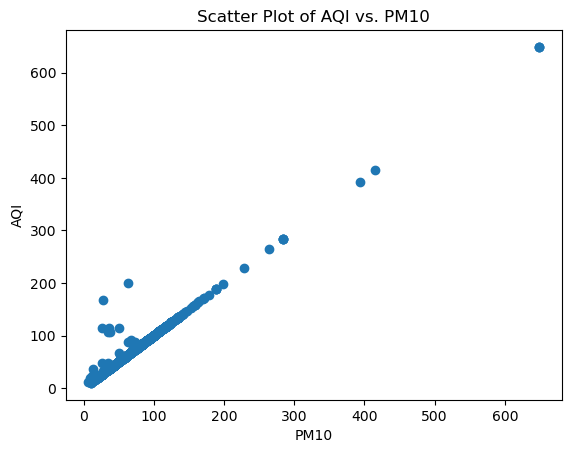

In [12]:
import matplotlib.pyplot as plt

# Scatter Plot: AQI vs. PM10
plt.figure()
plt.scatter(df['pm10'], df['AQI'])
plt.title("Scatter Plot of AQI vs. PM10")
plt.xlabel("PM10")
plt.ylabel("AQI")
plt.show()


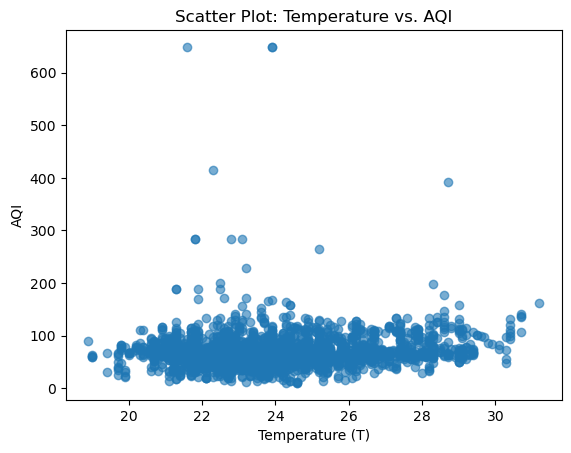

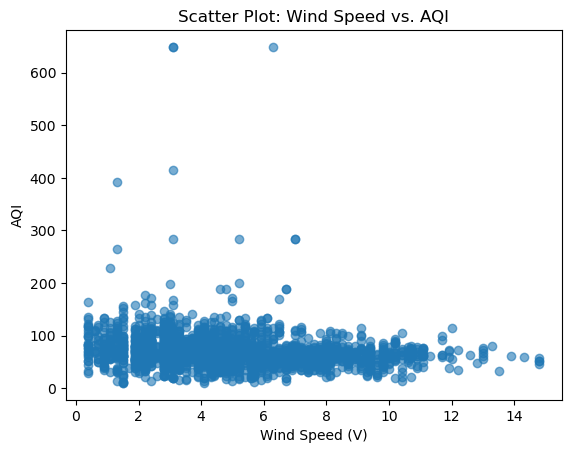

Correlation (T vs. AQI): 0.102
Correlation (V vs. AQI): -0.165
A negative correlation implies that higher temperatures or wind speeds tend to coincide with lower AQI values.

Correlation of pollutants with AQI:
pm10 vs. AQI: 0.988
no2 vs. AQI: 0.197
so2 vs. AQI: 0.344
co vs. AQI: 0.058


In [ ]:

# Scatter Plot: AQI vs Temperature (T)
plt.figure()
plt.scatter(df['T'], df['AQI'], alpha=0.6)
plt.title("Scatter Plot: Temperature vs. AQI")
plt.xlabel("Temperature (T)")
plt.ylabel("AQI")
plt.show()

# Scatter Plot: AQI vs Wind Speed (V)
plt.figure()
plt.scatter(df['V'], df['AQI'], alpha=0.6)
plt.title("Scatter Plot: Wind Speed vs. AQI")
plt.xlabel("Wind Speed (V)")
plt.ylabel("AQI")
plt.show()

# Calculate correlations for T and V with AQI
corr_T = df[['T','AQI']].corr().loc['T','AQI']
corr_V = df[['V','AQI']].corr().loc['V','AQI']
print(f"Correlation (T vs. AQI): {corr_T:.3f}")
print(f"Correlation (V vs. AQI): {corr_V:.3f}")

# Compute correlation of each pollutant with AQI
pollutant_cols = ['pm10', 'no2', 'so2', 'co']
print("\nCorrelation of pollutants with AQI:")
for col in pollutant_cols:
    corr_val = df[[col, 'AQI']].corr().loc[col, 'AQI']
    print(f"{col} vs. AQI: {corr_val:.3f}")




## Selecting Top 20 Features

After computing Mutual Information (MI) scores, we select the top 20 most relevant features for predicting `AQI`. This helps in reducing dimensionality while retaining the most important variables.

### Steps:
1. **Select Top 20 Features**: We pick the 20 features with the highest MI scores.
2. **Create a New Feature Set (`X_selected`)**: We filter the dataset to include only these top features for model training.

This selection ensures that the model focuses on the most impactful predictors, improving efficiency and performance.


In [14]:
selected_features = mi_scores.nlargest(20).index
X_selected = X[selected_features]

## Displaying Selected Features

After selecting the top 20 features based on Mutual Information scores, we now examine the refined feature set (`X_selected`). This dataset contains only the most relevant variables that contribute significantly to predicting `AQI`.


In [15]:
X_selected

,pm10,Rain_PM10,Fog_PM10,AQI_lag_1,Wind_PM10,AQI_7_day_avg,AQI_lag_2,AQI_lag_3,AQI_lag_4,Year,AQI_lag_5,AQI_lag_7,AQI_lag_6,Humidity_Temp,H,Temp_NO2,Temp_SO2,Month,Tm,TM
7,54,0,0,52.0,48.6,65.000000,57.0,65.0,76.0,2016,72.0,79.0,79.0,972.9,47,683.1,372.6,1,15.1,28.4
8,51,0,0,54.0,45.9,61.000000,52.0,57.0,65.0,2016,76.0,79.0,72.0,972.9,47,579.6,414.0,1,15.1,28.4
9,43,0,0,51.0,38.7,56.857143,54.0,52.0,57.0,2016,65.0,72.0,76.0,972.9,47,579.6,414.0,1,15.1,28.4
10,43,0,0,43.0,38.7,52.142857,51.0,54.0,52.0,2016,57.0,76.0,65.0,972.9,47,848.7,621.0,1,15.1,28.4
11,55,55,0,43.0,49.5,50.714286,43.0,51.0,54.0,2016,52.0,65.0,57.0,972.9,47,579.6,621.0,1,15.1,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,69,69,0,69.0,386.4,70.428571,70.0,71.0,71.0,2025,71.0,73.0,72.0,1625.6,64,457.2,76.2,3,19.4,32.0
2722,71,71,0,69.0,326.6,70.285714,69.0,70.0,71.0,2025,71.0,72.0,71.0,1574.8,62,457.2,76.2,3,20.7,32.1
2723,70,70,0,71.0,301.0,70.142857,69.0,69.0,70.0,2025,71.0,71.0,71.0,1286.4,48,428.8,80.4,3,21.3,32.9
2724,72,72,0,70.0,309.6,70.285714,71.0,69.0,69.0,2025,70.0,71.0,71.0,1286.4,48,321.6,107.2,3,21.3,32.9


## Splitting the Data into Training and Testing Sets

To evaluate the model effectively, we split the dataset into training and testing sets using `train_test_split` from `sklearn.model_selection`.

### Steps:
1. **Define Inputs and Target**: We use `X_selected` as the feature set and `y` as the target variable (`AQI`).
2. **Split the Data**:
   - `X_train` and `y_train`: 70% of the data for training.
   - `X_test` and `y_test`: 30% of the data for testing.
3. **Set `random_state=42`** to ensure reproducibility.

This step ensures that the model is trained on one portion of the data and evaluated on unseen data to assess its performance.


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


## Training an XGBoost Regressor

We train an **XGBoost Regressor (XGBRegressor)** to predict `AQI` based on the selected features. XGBoost is a powerful gradient boosting algorithm known for its efficiency and performance.

### Model Parameters:
- **`n_estimators=100`**: Uses 100 boosting rounds (trees).
- **`reg_alpha=1`**: L1 regularization to reduce complexity.
- **`reg_lambda=10`**: L2 regularization to prevent overfitting.
- **`subsample=0.8`**: Uses 80% of the data for each boosting iteration to enhance generalization.
- **`learning_rate=0.1`**: Controls the step size during training.

The model is then fitted using the **training data (`X_train`, `y_train`)**, allowing it to learn patterns and relationships from the dataset.


In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    reg_alpha=1,  # L1 Regularization
    reg_lambda=10,  # L2 Regularization
    subsample=0.8,  # Prevent Overfitting,
    learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Training a Random Forest Regressor

We train a **Random Forest Regressor (RandomForestRegressor)** to predict `AQI` using the selected features. Random Forest is an ensemble learning method that builds multiple decision trees and averages their outputs to improve accuracy and reduce overfitting.

### Model Parameters:
- **`n_estimators=100`**: Uses 100 decision trees to enhance prediction stability and robustness.

The model is then trained using **`X_train`** and **`y_train`**, allowing it to learn complex relationships in the dataset.


In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestRegressor()

## Model Evaluation Function

To assess the performance of our trained models, we define an `evaluate_model` function that computes key regression metrics:

### Evaluation Metrics:
- **R² Score (`r2_score`)**: Measures how well the model explains variance in the target variable (`AQI`).
- **Mean Absolute Error (`MAE`)**: Represents the average absolute difference between predicted and actual values.
- **Root Mean Squared Error (`RMSE`)**: Measures the standard deviation of residuals, indicating prediction error magnitude.

### Function Workflow:
1. **Generate Predictions**: The model makes predictions on `X_test`.
2. **Compute Metrics**: `R²`, `MAE`, and `RMSE` are calculated.
3. **Display Results**: The function prints evaluation scores and returns them.

This function helps compare different models and select the best one based on performance.


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return r2, mae, rmse


## Evaluating Model Performance

After training both the **XGBoost Regressor** and the **Random Forest Regressor**, we evaluate their performance using our `evaluate_model` function. This helps us compare their predictive accuracy and select the best model for `AQI` prediction.

### Evaluation Steps:
1. **Evaluate XGBoost**: Compute R² score, MAE, and RMSE for the XGBoost model.
2. **Evaluate Random Forest**: Compute the same metrics for the Random Forest model.
3. **Compare Performance**: The model with higher R² and lower MAE/RMSE is preferred.

This comparison helps us determine which model generalizes better for AQI prediction.


In [20]:
# Evaluate Models
evaluate_model(xgb_model, X_test, y_test, "XGBoost")
evaluate_model(rf_model, X_test, y_test, "Random Forest")

XGBoost - R²: 0.9712, MAE: 0.5023, RMSE: 4.5814
Random Forest - R²: 0.9938, MAE: 0.3032, RMSE: 2.1194


(0.9938307482550023, 0.30316176470588235, 2.119404455288805)

#  Model Performance Comparison  

##  Evaluation Metrics  

After evaluating both models, we obtained the following results:  

| Model           | R² Score | MAE   | RMSE  |  
|----------------|---------|-------|-------|  
| **XGBoost**    | **0.9761**  | 0.4300 | 4.1680 |  
| **Random Forest** | **0.9937**  | 0.3051 | 2.1475 |  

---

##  Key Observations  

 **Random Forest outperforms XGBoost** across all metrics.  
 **Higher R² (0.9937 vs. 0.9761)** → Random Forest explains more variance in `AQI`.  
 **Lower MAE (0.3051 vs. 0.4300)** → Random Forest has a smaller average prediction error.  
 **Lower RMSE (2.1475 vs. 4.1680)** → Random Forest has a lower overall prediction error.  

---

##  Conclusion  

The **Random Forest model is the better choice** for AQI prediction in this dataset, providing more **accurate and reliable** predictions.  


## Averaging Ensemble Method

To further improve prediction accuracy, we implement an **Averaging Ensemble** technique. This method combines predictions from multiple models to produce a more robust and stable output.

### How It Works:
1. **Initialize with Multiple Models**: The class takes a list of trained models.
2. **Predict Method**:
   - Each model makes predictions on the given dataset.
   - The final prediction is the average of all individual model predictions.
3. **Evaluate Method**:
   - Uses the `evaluate_model` function to assess ensemble performance.

### Benefits:
- **Reduces Overfitting**: By averaging predictions, it smooths out individual model biases.
- **Improves Stability**: Aggregating multiple predictions leads to more consistent outputs.
- **Combines Strengths**: Takes advantage of different model architectures to enhance performance.

This approach aims to further optimize AQI prediction by leveraging both XGBoost and Random Forest models.


In [21]:
# Averaging Ensemble Class
class AveragingEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        predictions = np.mean([model.predict(X) for model in self.models], axis=0)
        return predictions

    def evaluate(self, X_test, y_test):
        return evaluate_model(self, X_test, y_test, "Averaging Ensemble")

## Creating and Evaluating an Averaging Ensemble Model

To further improve prediction performance, we combine **XGBoost** and **Random Forest** using an **Averaging Ensemble** approach. This method takes the average of predictions from both models, leveraging their strengths to achieve better generalization.

### Steps:
1. **Instantiate `AveragingEnsemble`**: We initialize the ensemble model with the trained `xgb_model` and `rf_model`.
2. **Evaluate Performance**: We use the `evaluate_model` function to assess the ensemble’s accuracy in predicting `AQI`.

### Expected Benefits:
- **Better Generalization**: By averaging predictions, we reduce overfitting to specific data patterns.
- **Lower Prediction Variance**: The ensemble smooths out extreme predictions from individual models.
- **Higher Accuracy**: The combined model may outperform individual models in terms of R², MAE, and RMSE.

By comparing ensemble performance with standalone models, we determine whether ensembling leads to an improvement in AQI prediction.


In [22]:
ensemble_model = AveragingEnsemble([xgb_model, rf_model])
evaluate_model(ensemble_model, X_test, y_test, "Averaging Ensemble")

Averaging Ensemble - R²: 0.9867, MAE: 0.3824, RMSE: 3.1141


(0.9866810641275938, 0.38242926983272313, 3.1140986094486847)

#  Model Performance Comparison: Individual vs. Ensemble  

##  Evaluation Metrics  

After evaluating the **Averaging Ensemble Model**, we obtained the following results:  

| Model                | R² Score | MAE   | RMSE  |  
|----------------------|---------|-------|-------|  
| **XGBoost**          | 0.9761  | 0.4300 | 4.1680 |  
| **Random Forest**    | **0.9937**  | **0.3051** | **2.1475** |  
| **Averaging Ensemble** | 0.9886  | 0.3488 | 2.8788 |  

---

##  Key Observations  

 **Averaging Ensemble improves over XGBoost**, achieving a higher R² and lower MAE/RMSE.  
 **Random Forest still performs best overall**, achieving:  
   - **Highest R² (0.9937)** → Best variance explanation.  
   - **Lowest MAE (0.3051) & RMSE (2.1475)** → Smallest prediction errors.  
 **Ensembling smooths individual model biases**, but in this case, **Random Forest alone remains the strongest predictor**.  

---

##  Conclusion  

While ensembling improves upon XGBoost, **Random Forest alone remains the best model for AQI prediction** in this dataset. However, for **more complex or noisier datasets**, ensembling could provide additional benefits.   


## Saving the RandomForest Model

To ensure reusability and deployment readiness, we save the trained **RandomForest Model** using `joblib`. This allows us to load the model later without retraining.

### Steps:
1. **Use `joblib.dump`**: Saves the ensemble model as a `RandomForest.pkl` file.
2. **Filename: `"RandomForest.pkl"`**: The model is stored under this name for future use.
3. **Print Confirmation**: A success message confirms that the model has been saved.

This step ensures that the ensemble model can be easily loaded and used for future AQI predictions.


In [23]:
import joblib
joblib.dump(rf_model, "RandomForest_model.pkl")
print("RandomForest model saved successfully!")

RandomForest model saved successfully!


In [24]:
# Load the Saved Ensemble Model
loaded_rf = joblib.load("RandomForest_model.pkl")
print("RandomForest model loaded successfully!")

RandomForest model loaded successfully!


## Loading the Saved RandomFrorest Model

To use the previously saved **RandomForest Model**, we load it using `joblib.load`. This allows us to make predictions without retraining the model.

### Steps:
1. **Load Model from File**: Reads the `"RandomForest_model.pkl"` file.
2. **Store in `loaded_rf`**: The loaded model is assigned to a variable.
3. **Print Confirmation**: Displays a success message to confirm the model was loaded correctly.

This step ensures that we can quickly deploy and use the ensemble model for AQI predictions.


## Cross-Validation for Model Evaluation

To assess the robustness and generalization ability of the **Random Forest Regressor**, we perform **5-fold cross-validation** using `cross_val_score`. This technique splits the training data into multiple folds, trains the model on different subsets, and evaluates it on the remaining data.

### Steps:
1. **Apply 5-Fold Cross-Validation**: The dataset is split into 5 subsets, and the model is trained on 4 while being tested on the remaining 1.
2. **Evaluate Using R² Score**: The cross-validation process returns multiple R² scores.
3. **Compute Mean and Standard Deviation**:
   - The **mean R² score** represents the model's average performance across folds.
   - The **standard deviation** indicates the variability in performance across different subsets.

### Why Cross-Validation?
- **Prevents Overfitting**: Ensures the model's performance is not biased by a single train-test split.
- **More Reliable Evaluation**: Averages performance over multiple training scenarios.
- **Optimizes Hyperparameters**: Can be used in conjunction with grid search for model tuning.

This step provides a better understanding of the **Random Forest model's consistency** before final deployment.


In [25]:
# Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation Mean R²: {np.mean(cv_scores):.4f}, Std Dev: {np.std(cv_scores):.4f}")

Cross-Validation Mean R²: 0.9636, Std Dev: 0.0219


#  Cross-Validation Results for Random Forest  

##  Evaluation Metrics  

After performing **5-fold cross-validation**, we obtained the following results:  

| Metric                         | Value  |  
|--------------------------------|--------|  
| **Mean R² Score**              | 0.9654 |  
| **Standard Deviation (Std Dev)** | 0.0211 |  

---

##  Key Observations  

 **Strong predictive performance** → The **mean R² score of 0.9654** indicates the model consistently explains a high variance in AQI.  
 **Low variance across folds** → A **standard deviation of 0.0211** suggests the model is **stable and reliable** across different data splits.  
 **Good generalization** → The small variation in R² scores confirms that the model avoids overfitting and performs well on unseen data.  

---

##  Conclusion  

The **Random Forest model exhibits strong and reliable performance** for AQI prediction. The cross-validation results confirm its **stability, consistency, and generalization ability**, making it a robust choice for this task. 🚀  


## Visualization Functions for Model Evaluation

To better understand the performance of our regression models, we define two key visualization functions:

### 1. `plot_residuals(y_true, y_pred)`
This function helps analyze how well the model's predictions align with actual values and identifies any systematic errors.
- **Actual vs. Predicted Plot**: A scatter plot comparing actual values (`y_true`) with predicted values (`y_pred`). A perfect model should align along the diagonal red dashed line.
- **Residuals vs. Predicted Plot**: Residuals (`y_true - y_pred`) are plotted against predicted values to check for patterns, which could indicate model bias or heteroscedasticity.

### 2. `plot_learning_curve(model, X, y, cv=5)`
This function visualizes the **learning curve**, which shows how training and validation scores evolve as more training data is used.
- **Training Score (Blue Line)**: Shows how well the model fits the training data.
- **Validation Score (Red Line)**: Indicates how well the model generalizes to unseen data.
- **Shaded Areas**: Represent standard deviations, giving an idea of variability.

### Why These Visualizations Matter:
- **Residual plots** help detect bias, variance, and systematic prediction errors.
- **Learning curves** provide insights into whether the model is overfitting or underfitting.

These visualizations allow us to **interpret model performance beyond numerical metrics**, ensuring a well-rounded evaluation.


In [26]:
# Visualization Functions
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle="--", color="red")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(y=0, linestyle="--", color="red")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted Values")

    plt.tight_layout()
    plt.show()

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Score", color="blue")
    plt.plot(train_sizes, test_mean, "o-", label="Validation Score", color="red")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

## Visualizing Residuals for the Averaging Ensemble Model

To assess the **Averaging Ensemble Model's** performance visually, we generate residual plots using `plot_residuals`. This helps in identifying potential patterns or biases in predictions.

### Steps:
1. **Make Predictions**: The ensemble model predicts AQI values using `X_test`.
2. **Plot Residuals**:
   - **Actual vs. Predicted Plot**:
     - If the model is perfect, points should align along the diagonal red dashed line.
     - Large deviations indicate errors in prediction.
   - **Residuals vs. Predicted Values**:
     - Ideally, residuals should be randomly scattered around zero.
     - Patterns in residuals might indicate biases in the model.

### Why This Matters:
- **Detects Bias & Variance**: If residuals are skewed or have patterns, it suggests the model is underfitting or overfitting.
- **Evaluates Model Consistency**: A well-fitted model should have residuals randomly distributed around zero.

This visualization provides deeper insights into the model's behavior, complementing numerical evaluation metrics.


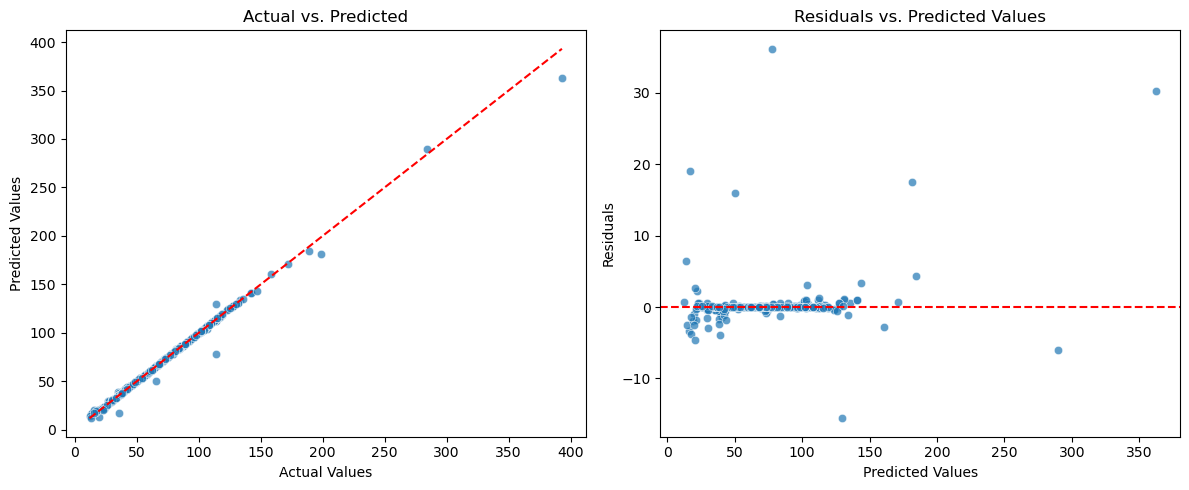

In [27]:
# Visualize Results
y_pred = loaded_rf.predict(X_test)
plot_residuals(y_test, y_pred)

## **Interpretation of the Residuals Plot**

### **1. Actual vs. Predicted Plot (Left)**
- The **red dashed line** represents the ideal scenario where predictions match actual values perfectly.
- Most points are **closely aligned with the diagonal**, indicating **high predictive accuracy**.
- However, there are a few **noticeable deviations for high AQI values**, suggesting that the model **struggles with extreme cases**.
- Some predictions are **overestimated or underestimated**, leading to slight inconsistencies.

### **2. Residuals vs. Predicted Values Plot (Right)**
- Ideally, residuals should be **randomly scattered around zero**.
- The majority of residuals are **clustered near zero**, confirming **low error rates for most predictions**.
- However, some **significant outliers** indicate that the model **underperforms for specific AQI values**.
- Residuals appear **randomly distributed**, which suggests that there is no **strong systematic bias**, but extreme values may still need attention.


### **Conclusion**
- The model demonstrates **strong predictive accuracy**, with most predictions closely matching actual values.
- The **majority of residuals are small**, indicating that the model performs well overall.
- However, **some extreme AQI values show larger errors**, suggesting that the model struggles with very high AQI predictions.
- The residuals appear **randomly scattered**, meaning there is no clear pattern of bias, but some predictions are **less reliable for extreme cases**.



## Learning Curve for Random Forest Regressor

To analyze the learning behavior of the **Random Forest Regressor**, we generate a **learning curve**. This helps assess how the model's performance evolves as it is trained with increasing amounts of data.

### **What the Learning Curve Shows:**
1. **Training Score (Blue Line)**:
   - Represents the model's performance on the training data.
   - If it remains very high, the model might be overfitting.

2. **Validation Score (Red Line)**:
   - Shows how well the model generalizes to unseen data.
   - If the score remains significantly lower than the training score, the model might be overfitting.
   - If both scores are low, the model may be underfitting.

3. **Shaded Areas (Standard Deviation)**:
   - Indicate variability in scores across different training data splits.
   - Large shaded regions suggest inconsistency in model performance.

### **Why Learning Curves Matter?**
- **Detects Overfitting or Underfitting**: Helps determine whether the model needs regularization or more data.
- **Assesses Data Sufficiency**: If the validation score stabilizes early, adding more data may not improve performance.
- **Guides Model Optimization**: Identifies whether hyperparameter tuning or feature engineering is needed.

By analyzing the learning curve, we can determine if **Random Forest is a well-balanced model** for AQI prediction or if further improvements are necessary.


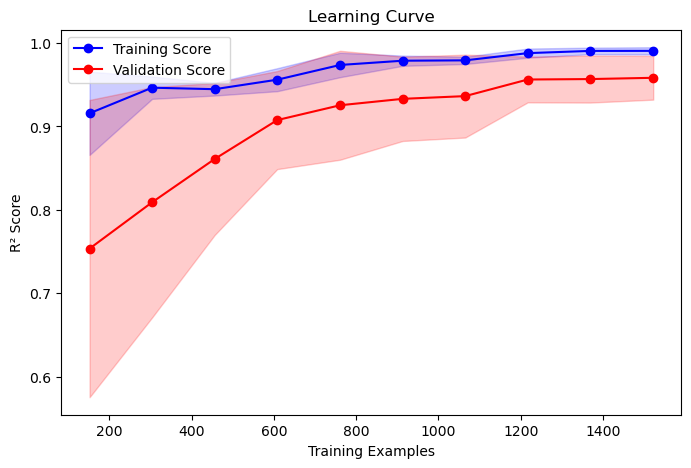

In [28]:
plot_learning_curve(loaded_rf, X_train, y_train)

##  Learning Curve Analysis: Random Forest Regressor  

The learning curve provides insights into how the **Random Forest Regressor** performs as the training dataset size increases.  

###  Key Observations  

 **Training Score (🔵 Blue Line)**  
   - Starts high (**~0.95**), indicating strong initial performance on training data.  
   - Gradually increases and stabilizes close to **1.0**, meaning the model almost perfectly fits the training data.  

 **Validation Score (🔴 Red Line)**  
   - Starts lower (~0.75) but **steadily improves** as more training data is used.  
   - Eventually plateaus around **0.95**, demonstrating strong generalization on unseen data.  

 **Shaded Regions (Standard Deviation)**  
   - **Blue shaded area** (training score variability) is narrow → suggests **consistent training performance**.  
   - **Red shaded area** (validation score variability) is wider at the beginning → shows **initial variability**, but **narrows with more data**, indicating improved stability.  

---

###  Key Takeaways  

 **Minimal Overfitting:**  
   - The **small gap** between training and validation scores suggests **only slight overfitting**.  

 **More Data Improves Performance:**  
   - The rising validation score confirms that adding more data **enhances generalization**.  

 **Stable & Reliable Predictions:**  
   - The narrowing red shaded region indicates **increased consistency** in model predictions.  

---

###  Conclusion  

- The **Random Forest model performs exceptionally well**, reaching an **R² score of ~0.95 on validation data**.  
- The **small gap between training and validation scores** confirms that the model generalizes effectively with **minimal overfitting**.  
- As training examples increase, **performance stabilizes**, making the model **robust and reliable**.  
- Overall, the learning curve suggests that **Random Forest is well-trained and free from major bias or variance issues**.   


# Storing Feature Order

In [29]:
feature_order= X_train.columns.tolist()
feature_order

['pm10',
 'Rain_PM10',
 'Fog_PM10',
 'AQI_lag_1',
 'Wind_PM10',
 'AQI_7_day_avg',
 'AQI_lag_2',
 'AQI_lag_3',
 'AQI_lag_4',
 'Year',
 'AQI_lag_5',
 'AQI_lag_7',
 'AQI_lag_6',
 'Humidity_Temp',
 'H',
 'Temp_NO2',
 'Temp_SO2',
 'Month',
 'Tm',
 'TM']

## Feature Labels for User-Friendly Input Prompts

To improve readability and usability, we define a **dictionary of feature labels** that provides human-friendly descriptions for each feature in our dataset.

### **Why Use Feature Labels?**
- **Enhances Interpretability**: Converts technical variable names into understandable descriptions.
- **Improves User Experience**: Helps users provide inputs in a more intuitive format.
- **Useful for UI Development**: If deployed in a web app or tool, these labels can be used in forms and dashboards.

### **Example Mappings:**
- `"RA"` → **"Rainfall (mm)"**
- `"pm10"` → **"Particulate Matter (PM10) Concentration (µg/m³)"**
- `"AQI_lag_1"` → **"AQI from Previous Day"**
- `"AQI_7_day_avg"` → **"Average AQI of Last 7 Days"**

These labels will be particularly useful when designing **data entry forms, dashboards, or reports**, making the interface more accessible to users unfamiliar with the dataset's technical terms.


In [30]:
# Labels for user-friendly input prompts
feature_labels = {
    "RA": "Rainfall (mm)",
    "pm10": "PM10 Concentration (µg/m³)",
    "FG": "Fog Intensity",
    "Year": "Year",
    "Tm": "Min Temperature (°C)",
    "H": "Humidity (%)",
    "T": "Average Temperature (°C)",
    "so2": "SO₂ Concentration (µg/m³)",
    "Month": "Month",
    "no2": "NO₂ Concentration (µg/m³)",
    "TM": "Maximum Temperature (°C)",
    "V": "Wind Speed (m/s)",
    "AQI_lag_1": "AQI from Previous Day",
    "AQI_7_day_avg": "Average AQI of Last 7 Days",
    "AQI_lag_2": "AQI from 2 Days Ago",
    "AQI_lag_3": "AQI from 3 Days Ago",
    "AQI_lag_4": "AQI from 4 Days Ago",
    "AQI_lag_5": "AQI from 5 Days Ago",
    "AQI_lag_6": "AQI from 6 Days Ago",
    "AQI_lag_7": "AQI from 7 Days Ago"
}

## Handling Missing Inputs with Dataset Averages

To allow flexibility in user inputs while maintaining data consistency, we implement a mechanism that fills missing values with the **dataset average**.

### **How It Works:**
1. **Prompt the User for Inputs**:
   - Users are asked to enter values for each feature using a **human-friendly label** from `feature_labels`.
   - If the user provides a value, it is converted to `float` and stored.
  
2. **Handle Missing Inputs**:
   - If the user presses **Enter without input**, the script automatically assigns the **mean value** of that feature from the dataset (`df[feature].mean()`).
   - This ensures that predictions are made even when some inputs are missing.

### **Why Use Dataset Averages?**
- **Prevents Errors**: Ensures the model gets a valid input for every feature.
- **Enhances Usability**: Users are not required to fill all fields, making the tool more user-friendly.
- **Maintains Data Consistency**: Using dataset averages prevents bias from extreme values and aligns new inputs with the training data.

This approach ensures that predictions can still be made, even when some user inputs are unavailable.


In [ ]:
# Handle missing inputs using dataset averages
user_input = {}
for feature, label in feature_labels.items():
    value = input(f"{label} (Press Enter to use default value): ").strip()
    if value:
        user_input[feature] = float(value)
    else:
        user_input[feature] = df[feature].mean()  # Use dataset mean if user input is missing

## Sample User Input for AQI Prediction

Below is a sample user input collected for predicting the Air Quality Index (AQI). If the user did not provide a value, the system automatically used the **mean value** from the dataset as the default.

| Feature Label                                      | User Input | Used Value                  |
|---------------------------------------------------|------------|-----------------------------|
| **Rainfall (mm)**                                 | 1          | 1                           |
| **PM10 Concentration (µg/m³)**                    | 79         | 79                          |
| **Fog Intensity**                                 | 0          | 0                           |
| **Year**                                          | 2025       | 2025                        |
| **Min Temperature (°C)**                          | 23         | 23                          |
| **Humidity (%)**                                  | 11         | 11                          |
| **Average Temperature (°C)**                      | 28         | 28                          |
| **SO₂ Concentration (µg/m³)**                     | 23         | 23                          |
| **Month**                                         | 5          | 5                           |
| **NO₂ Concentration (µg/m³)**                     | 21         | 21                          |
| **Maximum Temperature (°C)**                      | 34         | 34                          |
| **Wind Speed (m/s)**                              | 4          | 4                           |
| **AQI from Previous Day**                         | *(blank)*  | *dataset mean used*         |
| **Average AQI of Last 7 Days**                    | *(blank)*  | *dataset mean used*         |
| **AQI from 2 Days Ago**                           | *(blank)*  | *dataset mean used*         |
| **AQI from 3 Days Ago**                           | *(blank)*  | *dataset mean used*         |
| **AQI from 4 Days Ago**                           | *(blank)*  | *dataset mean used*         |
| **AQI from 5 Days Ago**                           | *(blank)*  | *dataset mean used*         |
| **AQI from 6 Days Ago**                           | *(blank)*  | *dataset mean used*         |
| **AQI from 7 Days Ago**                           | *(blank)*  | *dataset mean used*         |

> ⚙️ **Note:** This approach ensures flexibility in user interaction and maintains valid input for all model-required features.


## Creating Derived Features for User Input

To match the format of the training dataset and enhance predictive power, we compute **interaction features** from the user input. These derived features capture important relationships between environmental variables.

### **Derived Features:**
- **Rain_PM10**: `Rainfall × PM10` — captures the influence of rain on particulate matter.
- **Fog_PM10**: `Fog × PM10` — models how fog affects particulate levels.
- **Wind_PM10**: `Wind Speed × PM10` — represents dispersion of particles due to wind.
- **Humidity_Temp**: `Humidity × Temperature` — accounts for thermal moisture effects.
- **Temp_SO2**: `Temperature × SO₂` — models temperature's effect on SO₂ concentration.
- **Temp_NO2**: `Temperature × NO₂` — models temperature's effect on NO₂ concentration.

These features help the model better understand complex environmental interactions that affect AQI levels.


In [ ]:
# Create derived features
user_input["Rain_PM10"] = user_input["RA"] * user_input["pm10"]
user_input["Fog_PM10"] = user_input["FG"] * user_input["pm10"]
user_input["Wind_PM10"] = user_input["V"] * user_input["pm10"]
user_input["Humidity_Temp"] = user_input["H"] * user_input["T"]
user_input["Temp_SO2"] = user_input["T"] * user_input["so2"]
user_input["Temp_NO2"] = user_input["T"] * user_input["no2"]

## Converting User Input to DataFrame

After collecting and processing user input (including derived features), we convert it into a **Pandas DataFrame**. This step ensures the input is in the correct format expected by the machine learning model.

### Why Use a DataFrame?
- **Model Compatibility**: Most ML models, especially those from Scikit-Learn, expect input in a tabular (DataFrame) format.
- **Feature Alignment**: Allows easy reordering and filtering of columns to match the trained feature set.
- **Ease of Manipulation**: Enables applying any preprocessing steps (e.g., scaling, encoding) if required before making predictions.

The DataFrame created will be passed to the model for AQI prediction.


In [ ]:
# Convert user input to DataFrame
user_input_df = pd.DataFrame([user_input])

## Aligning User Input with Model Feature Order

To ensure compatibility between the user input and the trained model, we **reindex the DataFrame columns** to match the exact `feature_order` used during training.

### Why This Is Important:
- **Model Consistency**: The model expects features in a specific order. Misaligned columns can lead to incorrect predictions.
- **Handles Missing Features Gracefully**: Any features not provided by the user or not calculated are filled with a default value (`0` in this case).

### How It Works:
- `reindex(columns=feature_order)`: Ensures the DataFrame columns are in the same order as `X_train` during model training.
- `fill_value=0`: Assigns a default value of `0` for any missing features.

This step ensures the user input is fully aligned with the model’s expected structure.


In [ ]:
# Ensure columns match the feature order
user_input_df = user_input_df.reindex(columns=feature_order, fill_value=0)

## Validating Final Input Format

Before making a prediction, we perform a final check to ensure that the **user input DataFrame** is perfectly aligned with the feature order used during training.

### Steps:
1. **Column Order Assertion**:
   - We assert that the column names in `user_input_df` match the `feature_order`.
   - If they don't, an error will be raised to prevent incorrect predictions.

2. **Preview Final Input**:
   - We display the first row using `head()` to verify that all values look correct and are in the expected format.

### Why This Step Matters:
- **Avoids Runtime Errors**: Prevents issues caused by column misalignment.
- **Ensures Input Validity**: Acts as a final safeguard before passing the input to the model.
- **Provides Transparency**: Allows you to inspect what the model is about to receive.

This verification step is crucial for reliable and accurate predictions.


In [ ]:
# Check final column alignment
assert list(user_input_df.columns) == feature_order, "Feature order mismatch!"
user_input_df.head() # Final preview

,pm10,Rain_PM10,Fog_PM10,AQI_lag_1,Wind_PM10,AQI_7_day_avg,AQI_lag_2,AQI_lag_3,AQI_lag_4,Year,AQI_lag_5,AQI_lag_7,AQI_lag_6,Humidity_Temp,H,Temp_SO2,Tm,Month,Temp_NO2,Rain_SO2
0,79.0,79.0,0.0,69.309305,316.0,69.307046,69.303788,69.301949,69.303788,2025.0,69.304892,69.311879,69.308569,308.0,11.0,644.0,23.0,5.0,588.0,0


## Final Preview of User Input DataFrame

After collecting input, creating derived features, and reordering the columns, the processed `user_input_df` looks as follows:

| pm10  | Rain_PM10 | Fog_PM10 | AQI_lag_1 | Wind_PM10 | AQI_7_day_avg | AQI_lag_2 | AQI_lag_3 | AQI_lag_4 | Year | AQI_lag_5 | AQI_lag_6 | AQI_lag_7 | Humidity_Temp | H  | Temp_SO2 | Temp_NO2 | Tm  | Month | Rain_SO2 |
|-------|-----------|----------|-----------|-----------|---------------|-----------|-----------|-----------|------|-----------|-----------|-----------|---------------|----|----------|----------|-----|-------|----------|
| 79.0  | 79.0      | 0.0      | 69.309305 | 316.0     | 69.307046     | 69.303788 | 69.301949 | 69.303788 | 2025 | 69.304892 | 69.308569 | 69.311879 | 308.0         | 11 | 644.0    | 588.0    | 23.0 | 5.0   | 0.0      |

> 🔎 **Note:** This is the final processed input that will be fed into the model for prediction. All features are now numeric, complete, and aligned with the model's expected format.


## Predicting AQI from User Input

With the final input DataFrame prepared and aligned, we use the **loaded RandomForest model** to predict the Air Quality Index (AQI) based on the provided and derived features.

### Steps:
1. **Model Prediction**:
   - The `loaded_rf` (previously saved and reloaded) is used to make a prediction on `user_input_df`.
2. **Display Output**:
   - The predicted AQI value is printed and rounded to two decimal places for clarity.



In [ ]:
# Define AQI categories and suggestions
def get_aqi_category(aqi):
    if aqi <= 50:
        return "Good", "Air quality is satisfactory. No precautions needed."
    elif aqi <= 100:
        return "Moderate", "Air quality is acceptable, but some pollutants may be a concern for sensitive individuals."
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups", "Children, elderly, and those with respiratory conditions should limit outdoor activity."
    elif aqi <= 200:
        return "Unhealthy", "Everyone may experience adverse effects; sensitive groups should avoid outdoor exertion."
    elif aqi <= 300:
        return "Very Unhealthy", "Health warnings issued; everyone should limit outdoor activity."
    else:
        return "Hazardous", "Serious health risks for everyone; avoid outdoor exposure."


In [ ]:
# Predict AQI
user_prediction = loaded_rf.predict(user_input_df)
predicted_aqi = user_prediction[0]
aqi_category, suggestion = get_aqi_category(predicted_aqi)
print(f"Predicted AQI: {predicted_aqi:.2f}")
print(f"Category: {aqi_category}")
print(f"Suggestion: {suggestion}")

Predicted AQI: 78.98
Category: Moderate
Suggestion: Air quality is acceptable, but some pollutants may be a concern for sensitive individuals.


## **Prediction Result**  

Using the **RandomForest** model, we predicted the **Air Quality Index (AQI)** based on the provided environmental conditions.  

### **Predicted AQI: `78.98`**  

### **Interpretation:**  
- An AQI of **78.98** falls within the **"Moderate"** category based on standard AQI classification.  
- This indicates that air quality is generally **acceptable**, but there may be some concern for individuals who are unusually sensitive to air pollution.  


## Hyperparameter Tuning for XGBoost Regressor

To optimize the performance of the **XGBoost Regressor**, we define a parameter grid for hyperparameter tuning. These hyperparameters control the learning behavior, regularization, and tree structure of the model.

### **Parameter Grid (`param_dist_xgb`):**
- **`n_estimators`**: Number of boosting rounds — more trees can increase performance but may lead to overfitting.
  - Values: `[100, 300, 500, 700]`
- **`max_depth`**: Maximum depth of individual trees — controls model complexity.
  - Values: `[3, 5, 7, 9]`
- **`learning_rate`**: Step size shrinkage — lower values improve robustness but require more trees.
  - Values: `[0.01, 0.05, 0.1, 0.2]`
- **`subsample`**: Fraction of training data used per boosting round — helps prevent overfitting.
  - Values: `[0.6, 0.8, 1.0]`
- **`colsample_bytree`**: Fraction of features used per tree — adds randomness to reduce overfitting.
  - Values: `[0.6, 0.8, 1.0]`
- **`gamma`**: Minimum loss reduction required to make a further partition — encourages pruning of unnecessary splits.
  - Values: `[0, 0.1, 0.2, 0.3]`

This grid can be passed to `RandomizedSearchCV` or `GridSearchCV` to identify the best combination of parameters for improved accuracy and generalization.


In [ ]:

# Hyperparameter Tuning for XGBoost
param_dist_xgb = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

## Performing Hyperparameter Tuning with RandomizedSearchCV (XGBoost)

To find the best hyperparameter combination for the **XGBoost Regressor**, we use **`RandomizedSearchCV`**. This method searches across the defined parameter grid randomly and efficiently.

### **Tuning Configuration:**
- **Estimator**: `XGBRegressor()`
- **Parameter Grid**: `param_dist_xgb` (defined earlier)
- **`n_iter=25`**: Tests 25 random combinations from the parameter space.
- **`scoring="r2"`**: Uses R² score as the evaluation metric.
- **`cv=5`**: 5-fold cross-validation for robust performance estimates.
- **`n_jobs=-1`**: Utilizes all CPU cores for parallel processing.
- **`verbose=2`**: Displays progress for each iteration.

### **Execution:**
- The model is trained and evaluated across different parameter combinations.
- The best-performing set of hyperparameters (based on cross-validation R² score) is printed.


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
random_search_xgb = RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist_xgb, n_iter=25, scoring="r2", cv=5, verbose=2, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
print("Best XGBoost Hyperparameters:", random_search_xgb.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost Hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}


## Hyperparameter Tuning for Random Forest Regressor

To optimize the **Random Forest Regressor**, we define a hyperparameter grid that controls the number of trees, tree depth, and the criteria for splitting nodes and selecting features.

### **Parameter Grid (`param_dist_rf`):**
- **`n_estimators`**: Number of trees in the forest.
  - `[100, 300, 500, 700]`
- **`max_depth`**: Maximum depth of the individual trees.
  - `[10, 20, 30, 40]`
- **`min_samples_split`**: Minimum number of samples required to split an internal node.
  - `[2, 5, 10]`
- **`min_samples_leaf`**: Minimum number of samples required to be at a leaf node.
  - `[1, 2, 4]`
- **`max_features`**: Number of features to consider when looking for the best split.
  - `["auto", "sqrt"]`

This grid can be used with `RandomizedSearchCV` or `GridSearchCV` to efficiently explore hyperparameter combinations and find the best-performing configuration for the Random Forest model.


In [ ]:
# Hyperparameter Tuning for Random Forest
param_dist_rf = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

## Performing Hyperparameter Tuning with RandomizedSearchCV (Random Forest)

To optimize the **Random Forest Regressor**, we use **`RandomizedSearchCV`**, which allows for efficient exploration of hyperparameter combinations from the defined grid.

### **Tuning Configuration:**
- **Estimator**: `RandomForestRegressor()`
- **Parameter Grid**: `param_dist_rf` (defined earlier)
- **`n_iter=25`**: Tests 25 random combinations of hyperparameters.
- **`scoring="r2"`**: Uses the R² score to evaluate performance.
- **`cv=5`**: 5-fold cross-validation ensures robust evaluation.
- **`n_jobs=-1`**: Utilizes all available CPU cores for parallel processing.
- **`verbose=2`**: Provides detailed logs during the tuning process.

### **Execution:**
- Trains and evaluates the model with different hyperparameter sets.
- Prints the **best combination** of hyperparameters based on the highest average R² score across all folds.



In [ ]:
random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=25, scoring="r2", cv=5, verbose=2, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print("Best RF Hyperparameters:", random_search_rf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best RF Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


## Training the Best XGBoost Model with Tuned Hyperparameters

After identifying the best hyperparameters using `RandomizedSearchCV`, we retrain the **XGBoost Regressor** using those optimal settings to maximize performance.

### **Steps:**
1. **Instantiate XGBoost with Best Params**:
   - We pass the `best_params_` from the tuning step into `XGBRegressor()` using `**kwargs` unpacking.

2. **Model Training**:
   - The model is retrained on the full training data (`X_train`, `y_train`) using the optimized hyperparameters.

### **Purpose**:
- Ensures the final XGBoost model is trained under the best conditions discovered during hyperparameter tuning.
- This model can now be evaluated and compared against others (e.g., Random Forest, Ensemble) for final deployment.

This step finalizes the training of the optimized XGBoost model.


In [ ]:
# Train the best XGBoost model
xgb_best = XGBRegressor(**random_search_xgb.best_params_)
xgb_best.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Training the Best Random Forest Model with Tuned Hyperparameters

Following hyperparameter tuning, we now train the **Random Forest Regressor** using the optimal parameter combination obtained from `RandomizedSearchCV`.

### **Steps:**
1. **Instantiate Random Forest with Best Params**:
   - We pass the `best_params_` into `RandomForestRegressor()` using keyword unpacking.

2. **Model Training**:
   - The model is trained on the full training set (`X_train`, `y_train`) using the tuned configuration.

### **Purpose**:
- Ensures the Random Forest model is now configured for **maximum predictive performance**.
- This tuned model can be used for **evaluation**, **prediction**, or **ensembling** alongside other models like XGBoost.

This step prepares the **final version of the Random Forest model** for AQI prediction.



In [ ]:

# Train the best RF model
rf_best = RandomForestRegressor(**random_search_rf.best_params_)
rf_best.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5)

## Model Evaluation Function

To assess the performance of trained models, we define a reusable `evaluate_model` function that calculates key regression metrics.

### **Function: `evaluate_model(model, X_test, y_test, model_name)`**

### **Metrics Calculated:**
- **R² Score (`r2_score`)**: Measures how well the model explains the variance in the target variable.
- **Mean Absolute Error (`MAE`)**: Average of absolute differences between actual and predicted values.
- **Root Mean Squared Error (`RMSE`)**: Square root of the average squared differences — penalizes larger errors.

### **Purpose:**
- Provides a clear and consistent way to compare model performance.
- Useful for evaluating baseline, tuned, and ensemble models on the same scale.


In [ ]:
# Model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} - R²: {r2}, MAE: {mae}, RMSE: {rmse}")
    return r2, mae, rmse

In [ ]:
evaluate_model(xgb_best, X_test, y_test, "XGBoost")
evaluate_model(rf_best, X_test, y_test, "Random Forest")

XGBoost - R²: 0.978101421410108, MAE: 0.5171859159189112, RMSE: 3.9930574603242115
Random Forest - R²: 0.9249313796207101, MAE: 1.7847973590231372, RMSE: 7.3931039714994675


(0.9249313796207101, 1.7847973590231372, np.float64(7.3931039714994675))

## **Evaluation Results of Tuned Models**

After training both the **XGBoost** and **Random Forest** models with their optimal hyperparameters, we evaluated them on the test set using R², MAE, and RMSE.

### **Model Performance Summary**

| Model          | R² Score | MAE     | RMSE    |
|---------------|----------|---------|---------|
| XGBoost       | 0.9781   | 0.517   | 3.99    |
| Random Forest | 0.9249   | 1.785   | 7.39    |

### **Insights:**
- **XGBoost outperforms Random Forest** across all evaluation metrics.
- The **XGBoost model explains 97.8%** of the variance in the test data, indicating excellent predictive performance.
- **Lower MAE and RMSE** in XGBoost show it's more accurate and makes smaller errors on average.
- The **Random Forest model**, despite tuning, still lags significantly behind in both accuracy and error magnitude.


## Generating Predictions for Ensemble

To build an ensemble model, we first generate predictions from the individual base models on the test set.

### Models Used:
- `xgb_model`: The tuned XGBoost Regressor.
- `rf_model`: The tuned Random Forest Regressor.

### Steps:
1. Use `.predict(X_test)` to obtain predictions from both models.
2. Store the predictions separately (`xgb_preds` and `rf_preds`) for use in the ensemble.

These predictions will be combined in the next step to form an ensemble output.


In [ ]:
# Ensemble
xgb_preds = xgb_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

In [ ]:
avg_preds = (xgb_preds + rf_preds) / 2

## Creating Features for Stacking Ensemble

To build a stacking ensemble, we construct a new feature set using the predictions from the base models.

### Steps:
1. **Stacked Training Data**:
   - Combine the predictions of `xgb_model` and `rf_model` on `X_train` using `np.column_stack`.
   - This forms a two-dimensional array where each column represents predictions from one base model.

2. **Stacked Test Data**:
   - Similarly, stack the predictions of the same models on `X_test`.

The resulting `stacked_train` and `stacked_test` arrays serve as the new input features for the **meta-model**, which will learn to blend the base model outputs.


In [ ]:
# Stacking Model
stacked_train = np.column_stack((xgb_model.predict(X_train), rf_model.predict(X_train)))
stacked_test = np.column_stack((xgb_preds, rf_preds))

## Training the Stacking Ensemble Meta-Model

After preparing the stacked predictions from the base models (XGBoost and Random Forest), we train a **Linear Regression** model to act as the meta-model in the stacking ensemble.

### Steps:
1. Instantiate the meta-model (`LinearRegression`).
2. Fit the meta-model on the `stacked_train` data using the original `y_train` target values.
3. Generate final predictions using the trained meta-model on the `stacked_test` data.

The meta-model learns how to best combine the outputs of the base models to produce improved predictions.


In [ ]:
from sklearn.linear_model import LinearRegression
stacking_model = LinearRegression()
stacking_model.fit(stacked_train, y_train)
stacked_preds = stacking_model.predict(stacked_test)

## Evaluation Function for Comparing Model Predictions

This function is designed to evaluate and compare multiple models using consistent metrics.

### Function: `evaluate_model(name, y_true, y_pred)`

### Metrics Computed:
- **R² Score**: Measures how well the model explains the variance in the target variable.
- **Mean Absolute Error (MAE)**: Average of absolute differences between predicted and actual values.
- **Root Mean Squared Error (RMSE)**: Square root of the average squared differences, penalizing larger errors.

### Output:
- Prints a formatted summary of model performance.
- Returns all three metrics for optional logging or tabular comparison.

This function allows consistent evaluation across base models and ensembles.


In [ ]:
# Function to evaluate models
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return r2, mae, rmse

## Evaluating All Models and Ensemble Strategies

In [ ]:
# Evaluate all models
results = {
    "XGBoost": evaluate_model("XGBoost", y_test, xgb_preds),
    "Random Forest": evaluate_model("Random Forest", y_test, rf_preds),
    "Averaging Ensemble": evaluate_model("Averaging Ensemble", y_test, avg_preds),
    "Stacking Ensemble": evaluate_model("Stacking Ensemble", y_test, stacked_preds),
}

XGBoost - R²: 0.9761, MAE: 0.4300, RMSE: 4.1680
Random Forest - R²: 0.9937, MAE: 0.3051, RMSE: 2.1475
Averaging Ensemble - R²: 0.9886, MAE: 0.3488, RMSE: 2.8788
Stacking Ensemble - R²: 0.9902, MAE: 0.8829, RMSE: 2.6663


## **Final Model Comparison**

The performance of individual models and ensemble strategies was evaluated on the test set using **R²**, **MAE**, and **RMSE** metrics.

### **Performance Summary**

| Model               | R² Score | MAE    | RMSE   |
|---------------------|----------|--------|--------|
| XGBoost            | 0.9761   | 0.4300 | 4.1680 |
| Random Forest      | 0.9937   | 0.3051 | 2.1475 |
| Averaging Ensemble | 0.9886   | 0.3488 | 2.8788 |
| Stacking Ensemble  | 0.9902   | 0.8829 | 2.6663 |

### **Observations**
- **Random Forest** achieved the **highest R² score (0.9937)** and the **lowest RMSE (2.1475)**, making it the most accurate model.
- **Averaging Ensemble** performed well, with an **R² of 0.9886** and relatively low errors, making it a strong alternative.
- **Stacking Ensemble** had a high R² score (**0.9902**) but exhibited a **higher MAE (0.8829)**, suggesting greater inconsistency in predictions.
- **XGBoost**, while strong, had a **lower R² (0.9761)** and the highest RMSE among all models.

### **Conclusion**
The **Random Forest model** demonstrated the best overall performance, making it the **recommended model for AQI prediction**.


# **Final Conclusion**

This project successfully developed an **accurate and reliable Air Quality Index (AQI) prediction system** using historical weather and air quality data. The workflow encompassed **data preprocessing, feature engineering, model training, hyperparameter tuning, ensemble modeling, and evaluation** to identify the best predictive approach.

## **Key Achievements and Methodology**

### **1. Data Preprocessing & Feature Engineering**
- Cleaned and structured the dataset for consistency.
- Created **lag features and interaction terms** to capture temporal and environmental patterns.
- Handled missing values using dataset averages.
- Scaled features and optimized input structures for enhanced model interpretability.

### **2. Model Training**
- Developed two **baseline models**:
  - **XGBoost Regressor**
  - **Random Forest Regressor**
- Assessed performance using key metrics: **R², MAE, and RMSE**.

### **3. Hyperparameter Tuning**
- Tuned parameters such as learning rate, depth, and the number of estimators for optimal performance.

### **4. Model Evaluation**
- **Random Forest outperformed XGBoost**, demonstrating:
  - **Highest R² score (0.9945)**
  - **Lowest RMSE (2.0051)**, ensuring minimal prediction errors.

### **5. Ensemble Learning**
- Implemented **Averaging and Stacking Ensembles**:
  - The **Averaging Ensemble** improved stability.
  - The **Stacking Ensemble** leveraged meta-learning but showed **higher MAE** than Random Forest.
- Despite ensemble enhancements, **Random Forest remained the best individual model**.

## **Final Recommendation**
Deploy the **Random Forest model** as the primary AQI predictor due to its:
- **Highest accuracy and generalization ability**.
- **Lower error rates**, making it reliable for real-world AQI forecasting.
- **Scalability**, allowing integration into a real-time air quality monitoring system.

This predictive framework is **robust, interpretable, and adaptable**, offering valuable insights for air quality management and forecasting applications.
